# Notebook 2.1 - SegFormer inference
## INCISIVE model for MG segmentation
The purpose of this notebook is to present:
* INCISIVE model for MG segmentation
* how to use pretrained model
* what the challenges in MG segmentation are

## Installation of required packages
Select only missing packages

In [ ]:
! pip install numpy
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install pydicom
! pip install transformers
! pip install skimage
! pip install scipy
! pip install pandas
! pip install matplotlib
! pip install gdown

## Import of required packages and functions
Functions from skimage, scipy and pandars are required for image prepocessing
From classification point of view important packages are torch and transformers

In [1]:
import numpy as np
import torch
from pydicom import dcmread
from transformers import SegformerForSemanticSegmentation
from skimage.transform import resize, rescale
from scipy.ndimage import binary_erosion, binary_closing, binary_fill_holes, binary_dilation, label
from scipy.signal import convolve, find_peaks
from scipy.signal.windows import gaussian
from scipy.optimize import curve_fit
from pandas import Series
import matplotlib.pyplot as plt

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## How to load DICOM files

DICOM (Digital Imaging and Communications in Medicine) files are a standard format used in the medicine for storing and transmitting medical images and their associated information.

It consists of:
- Header - containing metadata that describes the patient, study, series, and image. It is organized as key value, wher the keys are predefined tags.
- Pixel Data - actual image data.

More information about DICOM tags you can find at https://www.dicomlibrary.com/dicom/dicom-tags/

In [2]:
def load_dcm_file(image_filename):
    image_dcm = dcmread(image_filename)
    image = image_dcm.pixel_array.astype('uint32')
    # Parse DICOM tags
    viewpos = 'N/A'
    if (0x0018, 0x5101) in image_dcm: #MLO/CC
        viewpos = image_dcm[0x0018, 0x5101].value
        if 'ML' in viewpos:
            viewpos = 'MLO'
        elif 'TAN' in viewpos:
            viewpos = 'MLO'
    # Convert image such that background is black
    requires_negation = False
    if (0x0028, 0x1041) in image_dcm: #	Pixel Intensity Relationship Sign
        if image_dcm[0x0028, 0x1041].value == 1:
            requires_negation = True
    if (0x2050, 0x0020) in image_dcm: #Presentation LUT Shape
        if image_dcm[0x2050, 0x0020].value == 'INVERSE':
            requires_negation = True
    if (0x0028, 0x0004) in image_dcm: #Photometric Interpretation
        if image_dcm[0x0028, 0x0004].value == 'MONOCHROME1':
            requires_negation = True
    if requires_negation:
        image = image.max() - image
    laterality_flag = True
    if (0x0020, 0x0062) in image_dcm:
        laterality = image_dcm[0x0020, 0x0062].value
    else:
        if image[:, 50:100].sum() > image[:, -100:-50].sum():
            laterality = 'L'
        else:
            laterality = 'R'
        laterality_flag = False
    if len(image.shape) > 2:
        image = image[:, :, 0]
    # Remove black border if exists
    y_start = next(i for i, v in enumerate(image) if v.sum() > 0)
    y_end = image.shape[0] - next(i for i, v in enumerate(image[::-1, :]) if v.sum() > 0)
    x_start = next(i for i, v in enumerate(image.T) if v.sum() > 0)
    x_end = image.shape[1] - next(i for i, v in enumerate(image[:, ::-1].T) if v.sum() > 0)
    image = image[y_start:y_end, x_start:x_end]
    # These DICOM tags are used in orignal application, but in this example they are superfluous
    if ((0x0018, 0x1152)) in image_dcm:
        info_exposure = float(image_dcm[0x0018, 0x1152].value)
    else:
        info_exposure = 'unknown'
    if ((0x0028, 0x1300)) in image_dcm:
        info_implant = str(image_dcm[0x0028, 0x1300].value)
    else:
        info_implant = 'unknown'
    if (0x0028, 0x0030) in image_dcm:
        pixel_spacing = float(image_dcm[0x0028, 0x0030].value[0])
        info_pixel_spacing = pixel_spacing
    else:
        pixel_spacing = 0.1
        info_pixel_spacing = 'unknown'
    image = np.round(rescale(image, scale=pixel_spacing / 0.1, preserve_range=True)).astype('uint32')
    return image.astype('float32'), image_dcm.pixel_array.astype('float32'), image_filename, (laterality, viewpos)


## Image preprocessing functions 

In [3]:
def gauss1(x, a1, b1, c1):
    return a1 * np.exp(-1 * ((x - b1) / c1) ** 2)


def get_lower(x, nbins=1001):
    x_min = x.min()
    x_max = x.max()
    xi = np.linspace(x_min, x_max, 1001)
    n = np.histogram(x, bins=xi)[0]
    argmax = np.argmax(n)
    if (argmax != 0) & (argmax < 100):
        n[:argmax] = 0
    elif (argmax != 0) & (argmax >= 100):
        n[0] = 0
    n = convolve(n, gaussian(25, 5.8), 'same')
    n /= n.max()
    xsup = min(x.mean(), max(np.percentile(x, 30), 0.2))
    idx, params = find_peaks(n * (xi[:-1] <= xsup), height=0.35)
    if idx.size == 1:
        select = (n > 0.35) & (xi[:-1] < xsup)
        try:
            popt, pcov = curve_fit(gauss1, xi[:-1][select], n[select], maxfev=5000)
            xth = popt[1] + np.sqrt(popt[2] ** 2 * (np.log(popt[0]) - np.log(0.05)))
        except:
            i_th = np.argwhere(n < 0.05)[0][0]
            xth = xi[i_th]
    elif idx.size > 1:
        n_min = min(n[idx.min():idx.max() + 1])
        i_min = np.argwhere(n == n_min)[0][0]
        select = (xi[:-1] >= xi[i_min]) & (n > 0.35) & (xi[:-1] < xsup)
        try:
            popt, pcov = curve_fit(gauss1, xi[:-1][select], n[select], maxfev=5000)
            xth = popt[1] + np.sqrt(popt[2] ** 2 * (np.log(popt[0]) - np.log(0.05)))
        except:
            i_th = np.argwhere(n < 0.05)[0][0]
            xth = xi[i_th]
    elif idx.size == 0:
        i_th = np.argwhere(n < 0.05)[0][0]  # ??? TODO
        xth = xi[i_th]
    return xth


def clean_mask(mask, iterations):
    # Erosion in order to remove thin lines in the background
    mask = binary_erosion(mask, iterations=iterations)
    # Select mask for largest connected component
    mask = get_mask_of_largest_connected_component(mask)
    # remove spurious holes
    mask = binary_closing(mask, iterations=iterations)
    mask = binary_fill_holes(mask)
    # Dilation to recover the original mask, excluding the thin lines
    mask = binary_dilation(mask, iterations=iterations)
    return mask


def seg_breast(image, laterality, n_iter=100):
    if laterality == 'R':
        image = image[:, ::-1]
    im = (image - image.min()) / (image.max() - image.min())
    xth = get_lower(im)
    mask = (im >= max(xth, 0))
    mask = clean_mask(mask, iterations=n_iter)
    return image, mask


# Finds the bounding box for the largest connected component
def get_edge_values(img, largest_mask, axis):
    assert axis in ["x", "y"]
    has_value = np.any(largest_mask, axis=int(axis == "y"))
    edge_start = np.arange(img.shape[int(axis == "x")])[has_value][0]
    edge_end = np.arange(img.shape[int(axis == "x")])[has_value][-1] + 1
    return edge_start, edge_end


# Gets the bottommost nonzero pixels of dilated mask before cropping
def get_bottommost_pixels(img, largest_mask, y_edge_bottom):
    bottommost_nonzero_y = y_edge_bottom - 1
    bottommost_nonzero_x = np.arange(img.shape[1])[largest_mask[bottommost_nonzero_y, :] > 0]
    return bottommost_nonzero_y, bottommost_nonzero_x


# Includes buffer in all sides of the image in y-direction
def include_buffer_y_axis(img, y_edge_top, y_edge_bottom, buffer_size):
    if y_edge_top > 0:
        y_edge_top -= min(y_edge_top, buffer_size)
    if y_edge_bottom < img.shape[0]:
        y_edge_bottom += min(img.shape[0] - y_edge_bottom, buffer_size)
    return y_edge_top, y_edge_bottom


# Includes buffer in only one side of the image in x-direction
def include_buffer_x_axis(img, mode, x_edge_left, x_edge_right, buffer_size):
    if mode == "left":
        if x_edge_left > 0:
            x_edge_left -= min(x_edge_left, buffer_size)
    else:
        if x_edge_right < img.shape[1]:
            x_edge_right += min(img.shape[1] - x_edge_right, buffer_size)
    return x_edge_left, x_edge_right

# Ignores top find_rightmost_from_ratio of the image and searches the rightmost nonzero pixels
# of the dilated mask from the bottom portion of the image.
def get_rightmost_pixels_wrt_cropped_image(mode, largest_mask_cropped, find_rightmost_from_ratio):
    ignore_height = int(largest_mask_cropped.shape[0] * find_rightmost_from_ratio)
    rightmost_pixel_search_area = largest_mask_cropped[ignore_height:, :]
    rightmost_pixel_search_area_has_value = np.any(rightmost_pixel_search_area, axis=0)
    rightmost_nonzero_x = np.arange(rightmost_pixel_search_area.shape[1])[
        rightmost_pixel_search_area_has_value][-1 if mode == 'right' else 0]
    rightmost_nonzero_y = np.arange(rightmost_pixel_search_area.shape[0])[
                              rightmost_pixel_search_area[:, rightmost_nonzero_x] > 0] + ignore_height
    # rightmost pixels are already found w.r.t. newly cropped image, except that we still need to
    #   reflect horizontal_flip
    if mode == "left":
        rightmost_nonzero_x = largest_mask_cropped.shape[1] - rightmost_nonzero_x
    return rightmost_nonzero_y, rightmost_nonzero_x


# Once the image is cropped, adjusts the bottommost pixel values which was originally w.r.t. the original image.
def convert_bottommost_pixels_wrt_cropped_image(mode, bottommost_nonzero_y, bottommost_nonzero_x,
                                                y_edge_top, x_edge_right, x_edge_left):
    bottommost_nonzero_y -= y_edge_top
    if mode == "left":
        bottommost_nonzero_x = x_edge_right - bottommost_nonzero_x  # in this case, not in sorted order anymore.
        bottommost_nonzero_x = np.flip(bottommost_nonzero_x, 0)
    else:
        bottommost_nonzero_x -= x_edge_left
    return bottommost_nonzero_y, bottommost_nonzero_x


#    If we fail to recover the original shape as a result of erosion-dilation
#    on the side where the breast starts to appear in the image,
#    we record this information.
def get_distance_from_starting_side(img, mode, x_edge_left, x_edge_right):
    if mode == "left":
        return img.shape[1] - x_edge_right
    else:
        return x_edge_left


# Finds the connected components from the mask of the image.
def get_masks_and_sizes_of_connected_components(img_mask):
    mask, num_labels = label(img_mask)
    mask_pixels_dict = {}
    for i in range(num_labels + 1):
        this_mask = (mask == i)
        if img_mask[this_mask][0] != 0:
            # Exclude the 0-valued mask
            mask_pixels_dict[i] = np.sum(this_mask)
    return mask, mask_pixels_dict


# Finds the largest connected component from the mask of the image.
def get_mask_of_largest_connected_component(img_mask):
    mask, mask_pixels_dict = get_masks_and_sizes_of_connected_components(img_mask)
    largest_mask_index = Series(mask_pixels_dict).idxmax()
    largest_mask = mask == largest_mask_index
    return largest_mask


def tonescale_LUT(image, mask, limits):
    nbits = np.ceil(np.log2(image.max())).astype(int)
    mask_tmp = binary_erosion(mask, iterations=25)
    hist_img = np.histogram(image[mask_tmp], bins=np.arange(2 ** nbits + 1), density=True)[0]
    hcumsum = np.cumsum(hist_img)
    intensity1 = np.argmin(hcumsum < limits[0])
    intensity2 = np.argmin(hcumsum < hcumsum[-1] - limits[1])
    lut1 = np.linspace(0, 0, intensity1 + 1)
    lut2 = np.linspace(0, 1, intensity2 - intensity1 + 1)
    lut3 = np.linspace(1, 1, 2 ** nbits - intensity2)
    LUT = np.concatenate((lut1[:-1], lut2[:-1], lut3), axis=0).astype('float32')
    return LUT


#     Performs erosion on the mask of the image, selects largest connected component,
#     dialates the largest connected component, and draws a bounding box for the result
#     with buffers.
#
#     input:
#         - img:   2D numpy array
#         - mode:  breast pointing left or right
#
#     models: a tuple of (window_location, rightmost_points,
#                         bottommost_points, distance_from_starting_side)
#         - window_location: location of cropping window w.r.t. original dicom image so that segmentation
#            map can be cropped in the same way for training.
#         - rightmost_points: rightmost nonzero pixels after correctly being flipped in the format of
#                             ((y_start, y_end), x)
#         - bottommost_points: bottommost nonzero pixels after correctly being flipped in the format of
#                              (y, (x_start, x_end))
#         - distance_from_starting_side: number of zero columns between the start of the image and start of
#            the largest connected component w.r.t. original dicom image.
def crop_img_from_largest_connected(img, laterality, iterations=100,
                                    buffer_size=50, find_rightmost_from_ratio=1 / 3):
    assert laterality in ("L", "R")
    if laterality == 'R':
        mode = 'left'
    else:
        mode = 'right'
    _, largest_mask = seg_breast(img, laterality, iterations)
    # figure out where to crop
    y_edge_top, y_edge_bottom = get_edge_values(img, largest_mask, "y")
    x_edge_left, x_edge_right = get_edge_values(img, largest_mask, "x")
    # extract bottommost pixel info
    bottommost_nonzero_y, bottommost_nonzero_x = get_bottommost_pixels(img, largest_mask, y_edge_bottom)
    # include maximum 'buffer_size' more pixels on both sides just to make sure we don't miss anything
    y_edge_top, y_edge_bottom = include_buffer_y_axis(img, y_edge_top, y_edge_bottom, buffer_size)
    # If cropped image not starting from corresponding edge, they are wrong. Record the distance, will reject if not 0.
    distance_from_starting_side = get_distance_from_starting_side(img, mode, x_edge_left, x_edge_right)
    # include more pixels on either side just to make sure we don't miss anything, if the next column
    #   contains non-zero value and isn't noise
    x_edge_left, x_edge_right = include_buffer_x_axis(img, mode, x_edge_left, x_edge_right, buffer_size)
    # convert bottommost pixel locations w.r.t. newly cropped image. Flip if necessary.
    bottommost_nonzero_y, bottommost_nonzero_x = convert_bottommost_pixels_wrt_cropped_image(
        mode,
        bottommost_nonzero_y,
        bottommost_nonzero_x,
        y_edge_top,
        x_edge_right,
        x_edge_left
    )
    # calculate rightmost point from bottom portion of the image w.r.t. cropped image. Flip if necessary.
    rightmost_nonzero_y, rightmost_nonzero_x = get_rightmost_pixels_wrt_cropped_image(
        mode,
        largest_mask[y_edge_top: y_edge_bottom, x_edge_left: x_edge_right],
        find_rightmost_from_ratio
    )
    # save window location in medical mode, but everything else in training mode
    return (y_edge_top, y_edge_bottom, x_edge_left, x_edge_right), \
           ((rightmost_nonzero_y[0], rightmost_nonzero_y[-1]), rightmost_nonzero_x), \
           (bottommost_nonzero_y, (bottommost_nonzero_x[0], bottommost_nonzero_x[-1])), \
           distance_from_starting_side, \
           largest_mask


def crop_mammogram(image, laterality, num_iterations=100, buffer_size=50):
    try:
        # error detection using erosion. Also get cropping information for this image.
        cropping_info = crop_img_from_largest_connected(image, laterality, num_iterations, buffer_size, 1 / 3)
    except Exception as error:
        print("\n\tFailed to crop image because image is invalid.", str(error))
    else:
        return cropping_info


def preprocess_YOLO(image, laterality, limits=(0.02, 0.01), LUT_process=True):
    image = image - image.min()
    if laterality == 'R':
        image = image[:, ::-1]
        laterality = 'L'
    cropping_info = crop_mammogram(image, laterality)
    if cropping_info:
        top, bottom, left, right = cropping_info[0]
    else:
        stop = 1
    image = image[top:bottom, left:right]
    crop_breast_mask = cropping_info[-1][top:bottom, left:right]
    if LUT_process:
        LUT = tonescale_LUT(image=image, mask=crop_breast_mask, limits=limits)
        image = LUT[image.astype(np.int32)]
    image = (image - image.min()) / (image.max() - image.min())
    return image, crop_breast_mask


def preprocess_MedT_full(image, laterality, out_size=(128, 128)):
    image, mask = preprocess_YOLO(image, laterality)
    orig_image_shape = image.shape
    image = resize(image, out_size)
    image = np.floor(image * 255)  # new in version 2
    return image, mask, orig_image_shape


## Download pretrained model and dcm files

In [4]:
! mkdir model
! gdown https://drive.google.com/uc?id=1tRf_KyuM4ihYL5tXYKEdPV-f7qZbVoc3  -O ./model/config.json
! gdown https://drive.google.com/uc?id=1DfL359oIcGmCem2OcguysTKKSOOkhWWT  -O ./model/pytorch_model.bin

Downloading...
From: https://drive.google.com/uc?id=1tRf_KyuM4ihYL5tXYKEdPV-f7qZbVoc3
To: d:\niksa\documents\courses\principi_dubokog_ucenja\auth_summer_school\ipynb\config.json

  0%|          | 0.00/1.11k [00:00<?, ?B/s]
100%|##########| 1.11k/1.11k [00:00<?, ?B/s]
Downloading...
From (original): https://drive.google.com/uc?id=1DfL359oIcGmCem2OcguysTKKSOOkhWWT
From (redirected): https://drive.google.com/uc?id=1DfL359oIcGmCem2OcguysTKKSOOkhWWT&confirm=t&uuid=2fc556f0-611d-4552-a9ad-de9afa073399
To: d:\niksa\documents\courses\principi_dubokog_ucenja\auth_summer_school\ipynb\pytorch_model.bin

  0%|          | 0.00/256M [00:00<?, ?B/s]
  0%|          | 524k/256M [00:00<06:49, 624kB/s]
  0%|          | 1.05M/256M [00:01<06:45, 630kB/s]
  1%|          | 1.57M/256M [00:02<06:48, 624kB/s]
  1%|          | 2.10M/256M [00:03<06:39, 636kB/s]
  1%|1         | 2.62M/256M [00:04<06:39, 634kB/s]
  1%|1         | 3.15M/256M [00:05<06:59, 603kB/s]
  1%|1         | 3.67M/256M [00:05<06:51, 614kB/s]
 

In [6]:
! mkdir dcms
! gdown https://drive.google.com/uc?id=1cVFwuWiC9CEOC4dMqDDosaeo6sCcblqJ -O ./dcms/Image-170.dcm
! gdown https://drive.google.com/uc?id=1OSnooQoNGJMH9C1eKJQE_m5cbgid7FW6 -O ./dcms/Image-18.dcm

A subdirectory or file dcms already exists.
Downloading...
From: https://drive.google.com/uc?id=1cVFwuWiC9CEOC4dMqDDosaeo6sCcblqJ
To: d:\niksa\documents\courses\principi_dubokog_ucenja\auth_summer_school\ipynb\dcms\Image-170.dcm

  0%|          | 0.00/19.2M [00:00<?, ?B/s]
  3%|2         | 524k/19.2M [00:00<00:27, 688kB/s]
  5%|5         | 1.05M/19.2M [00:01<00:27, 654kB/s]
  8%|8         | 1.57M/19.2M [00:02<00:27, 640kB/s]
 11%|#         | 2.10M/19.2M [00:03<00:26, 633kB/s]
 14%|#3        | 2.62M/19.2M [00:04<00:26, 633kB/s]
 16%|#6        | 3.15M/19.2M [00:05<00:26, 610kB/s]
 19%|#9        | 3.67M/19.2M [00:05<00:25, 619kB/s]
 22%|##1       | 4.19M/19.2M [00:06<00:23, 626kB/s]
 25%|##4       | 4.72M/19.2M [00:07<00:22, 634kB/s]
 27%|##7       | 5.24M/19.2M [00:08<00:22, 631kB/s]
 30%|###       | 5.77M/19.2M [00:09<00:21, 628kB/s]
 33%|###2      | 6.29M/19.2M [00:10<00:20, 618kB/s]
 36%|###5      | 6.82M/19.2M [00:10<00:20, 611kB/s]
 38%|###8      | 7.34M/19.2M [00:11<00:19, 620kB/s]

## Load model

Our initial model was base on SegFormer model for segmentation of commong images implemented at HaggingFace https://huggingface.co/docs/transformers/en/model_doc/segformer

<img src="./figures/SegFormer.png" alt="SegFormer.png">

In [7]:
model_seg = SegformerForSemanticSegmentation.from_pretrained("./model")
model_seg.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## Model inference

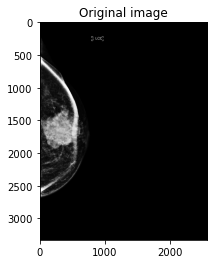

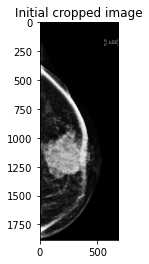

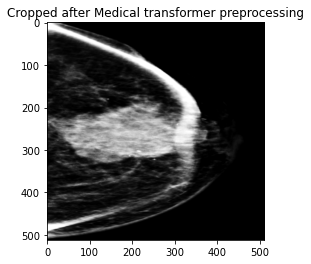

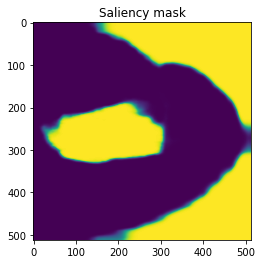

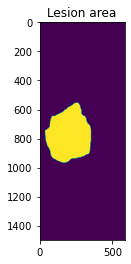

In [8]:
imgsize = 512
test_dataset = load_dcm_file("./dcms/Image-170.dcm")
plt.imshow(test_dataset[1], cmap="gray")
plt.title("Original image")
plt.show()
plt.imshow(test_dataset[0], cmap="gray")
plt.title("Initial cropped image")
plt.show()
image_segm, crop_breast_mask, orig_image_shape = preprocess_MedT_full(test_dataset[0], test_dataset[3][0],
                                                                      out_size=(imgsize, imgsize))
plt.imshow(image_segm, cmap="gray")
plt.title("Cropped after Medical transformer preprocessing")
plt.show()
x_batch = torch.tensor(image_segm, device="cpu", dtype=torch.float32).unsqueeze(0).unsqueeze(0)
x_batch = torch.cat((x_batch, x_batch, x_batch), 1)
output = model_seg(x_batch.to("cpu")).get('logits')
output = torch.nn.functional.interpolate(output, size=(imgsize, imgsize), mode='bilinear', align_corners=False)
y_out = torch.nn.functional.softmax(output.detach(), dim=1)
saliency_mask = y_out[0, 1, :, :]
plt.imshow(saliency_mask)
plt.title("Saliency mask")
plt.show()
prediction_mask = resize(saliency_mask.numpy(), orig_image_shape) * crop_breast_mask
final_prediction_mask = prediction_mask >= 0.5
plt.imshow(final_prediction_mask)
plt.title("Lesion area")
plt.show()

## Acknowledge

The code presented above is slightly modify version of the code created by my colleague Ivan Lazić for the Docker implementation of the INCISIVE MG segmentation tool.